In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.feature_selection import RFE

from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE

# Analysis of house sales data in New South Wales

The dataset is downloaded from the NSW Department of Family and Community Services. They published data on rental and house sales in different postcodes.

The following analysis is based on data from the following quarters: March 2021, June 2021, September 2021, December 2021, and March 2022 (1 full year).


# Purpose of analysis

Purpose of the exploration is to classify dwelling type based on post code, sales price or number of sales. 

Dwelling types strata means it's an apartment building, and non-strata usually means it's a house. We expect certain postcodes have more apartment buildings than houses or vice versa. Similarly, the price of houses and apartments could be sigfinifantly different, as well as the number of sales of each.

I plan to classify dwelling type based on the information we have on post code, sales price and number of sales of each type of dwelling.

In [91]:
df = pd.read_csv('data/Sales-March-2022-quarter.csv')
df.head(10)

,Quarter,Postcode,Dwelling Type,First Quartile Sales Price\n$'000s,Median Sales Price\n$'000s,Third Quartile Sales Price\n'000s,Mean Sales Price\n$'000s,Sales\nNo.,Qtly change in Median,Annual change in Median,Qtly change in Count,Annual change in Count
0,322,2000,Total,950,1300,1843,1731,126,8.33%,-14.47%,-50.00%,-37.00%
1,322,2000,Strata,950,1300,1843,1731,126,0.0833,-0.1447,-0.494,-0.37
2,322,2007,Total,725,930,1433,1079,39,19.54%,14.11%,-30.36%,30.00%
3,322,2007,Non Strata,-,-,-,-,-,-,-,-,-
4,322,2007,Strata,725,930,1200,1034,37,19.54%,21.97%,-33.93%,32.14%
5,322,2008,Total,711,930,1378,1098,43,-9.27%,10.71%,-20.37%,-14.00%
6,322,2008,Non Strata,-,-,-,-,-,-,-,-,-
7,322,2008,Strata,688,811,1070,900,35,-7.84%,9.89%,-7.89%,-2.78%
8,322,2009,Total,862,1100,2050,1427,49,-20.86%,-10.39%,-48.42%,-12.50%
9,322,2009,Strata,862,1100,2050,1427,49,-0.1897,-0.1039,-0.4674,-0.125


# Data exploration

This next section tries to explore if there any NA values, the number of unique values in each column, and explore if there are any special data entries that need to be made into integers, or be transformed into numbers.

- We see no NA value
- There are - and s values in the Sales number column and the Mean sales price column that need to be cleaned before we can do classification
- There are 581 Postcodes all in NSW region
- The quarter column identifies which quarter the data came from (0321 is March 2021, 0621 is June 2021, and so on).

In [57]:
#Checking for NA values

df.isna().sum()

Quarter                               0
Postcode                              0
Dwelling Type                         0
First Quartile Sales Price\n$'000s    0
Median Sales Price\n$'000s            0
Third Quartile Sales Price\n'000s     0
Mean Sales Price\n$'000s              0
Sales\nNo.                            0
Qtly change in Median                 0
Annual change in Median               9
Qtly change in Count                  0
Annual change in Count                9
dtype: int64

In [4]:
#Exploring how many unique values for each column

df.nunique()

Quarter                                  5
Postcode                               581
Dwelling Type                            3
First Quartile Sales Price\n$'000s    1557
Median Sales Price\n$'000s            1554
Third Quartile Sales Price\n'000s     1963
Mean Sales Price\n$'000s              2123
Sales\nNo.                             297
Qtly change in Median                 2972
Annual change in Median               3474
Qtly change in Count                  2406
Annual change in Count                2447
dtype: int64

In [92]:
#Exploring all unique values for dwelling type

df['Dwelling Type'].unique()

array(['Total', 'Strata', 'Non Strata'], dtype=object)

In [6]:
#Exploring all unique values for mean sales price

df["Mean Sales Price\n$'000s"].unique()

array(['1731', '1079', '-', ..., '429', '425', '216'], dtype=object)

In [7]:
#Exploring all unique values for sales number

df["Sales\nNo."].unique()

array(['126', '39', '-', '37', '43', '35', '49', '180', '36', '144',
       '132', '84', 's', '70', '57', '72', '60', '59', '46', '88', '67',
       '75', '41', '34', '66', '65', '155', '125', '50', '45', '32',
       '112', '69', '61', '131', '54', '77', '78', '33', '42', '85', '47',
       '64', '44', '31', '101', '38', '55', '159', '108', '94', '53',
       '40', '71', '87', '189', '127', '80', '86', '62', '170', '51',
       '119', '68', '156', '113', '100', '128', '56', '105', '164', '157',
       '82', '102', '92', '81', '89', '91', '312', '134', '178', '48',
       '97', '236', '109', '161', '153', '58', '163', '106', '123', '90',
       '260', '129', '52', '118', '79', '110', '98', '95', '395', '199',
       '196', '76', '160', '96', '63', '103', '154', '130', '148', '149',
       '278', '166', '115', '93', '287', '272', '288', '211', '140',
       '121', '104', '124', '186', '152', '83', '150', '135', '111',
       '145', '284', '162', '74', '171', '147', '282', '191', '210',


In [8]:
#Exploring all unique values for postcode

df["Postcode"].unique()

array([2000, 2007, 2008, 2009, 2010, 2011, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2060, 2061,
       2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072,
       2073, 2074, 2075, 2076, 2077, 2079, 2081, 2082, 2083, 2084, 2085,
       2086, 2087, 2088, 2089, 2090, 2092, 2093, 2094, 2095, 2096, 2097,
       2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2110,
       2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121,
       2122, 2125, 2126, 2127, 2128, 2130, 2131, 2132, 2133, 2134, 2135,
       2136, 2137, 2138, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147,
       2148, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159,
       2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2170, 2171,
       2172, 2173, 2174, 2175, 2176, 2177, 2178, 21

# Data cleaning

This next section aims to clean up the data:

- We would be transforming the Postcode, Dwelling type into number labels
- We drop the columns that are not important: 'Qtly change in Median', 'Annual change in Count', 'Qtly change in Count', 'Annual change in Median', "First Quartile Sales Price\n'000s", "Median Sales Price\n'000s", "Third Quartile Sales Price\n'000s"
- We delete all rows with values '-' and 's'
- We turn the columns' values from str to int values
- We will also rename the columns for easier manipulation

- After deleting all the rows not useful, we went from 7159 rows to 3614 rows

In [10]:
#Getting all column names

df.columns

Index(['Quarter', 'Postcode', 'Dwelling Type',
       'First Quartile Sales Price\n$'000s', 'Median Sales Price\n$'000s',
       'Third Quartile Sales Price\n'000s', 'Mean Sales Price\n$'000s',
       'Sales\nNo.', 'Qtly change in Median', 'Annual change in Median',
       'Qtly change in Count', 'Annual change in Count'],
      dtype='object')

In [59]:
#Getting shape of dataframe

df.shape

(7159, 12)

In [93]:
#Transforming the Postcode values

ord_enc = OrdinalEncoder()

df["Postcode_code"] = ord_enc.fit_transform(df[["Postcode"]])

In [94]:
#Transforming the Dwelling type values

df["Dwelling_Type_code"] = ord_enc.fit_transform(df[["Dwelling Type"]])

In [95]:
#Deleting all the rows where sales price is unknown

df = df[df["Mean Sales Price\n$'000s"] != '-']

In [96]:
#Deleting all the rows where sales number is unknown

df = df[df["Sales\nNo."] != '-']

In [97]:
#Deleting all the rows where sales number is unknown

df = df[df["Sales\nNo."] != 's']

In [98]:
#Dropping all the columns not necessary

df = df.drop(labels=['Qtly change in Median', 'Annual change in Count', 'Qtly change in Count', 'Annual change in Median', "First Quartile Sales Price\n$'000s",
       "Median Sales Price\n$'000s", "Third Quartile Sales Price\n'000s"], axis=1)

In [99]:
df = df[df["Mean Sales Price\n$'000s"] != '1,005']

In [100]:
#Changing from type str to int

df = df.astype({"Mean Sales Price\n$'000s":"int","Sales\nNo.":"int"})

In [101]:
#Renaming columns for easier use

df = df.rename(columns={"Mean Sales Price\n$'000s": 'meansales1k', 'Sales\nNo.': 'salesno'})

In [102]:
#Checking the shape of dataframe after data cleasing

df.shape

(3613, 7)

In [103]:
#Descriptive statistics for the data set

df.describe()

,Quarter,Postcode,meansales1k,salesno,Postcode_code,Dwelling_Type_code
count,3613.000000,3613.000000,3613.000000,3613.000000,3613.000000,3613.000000
mean,698.729034,2317.377802,1214.669250,91.919734,227.115417,1.110711
std,350.458726,238.445742,928.085021,65.106363,155.652146,0.894445
min,321.000000,2000.000000,146.000000,31.000000,0.000000,0.000000
25%,322.000000,2121.000000,707.000000,46.000000,99.000000,0.000000
50%,621.000000,2250.000000,962.000000,70.000000,194.000000,1.000000
75%,921.000000,2500.000000,1449.000000,115.000000,354.000000,2.000000
max,1221.000000,2880.000000,18066.000000,498.000000,580.000000,2.000000


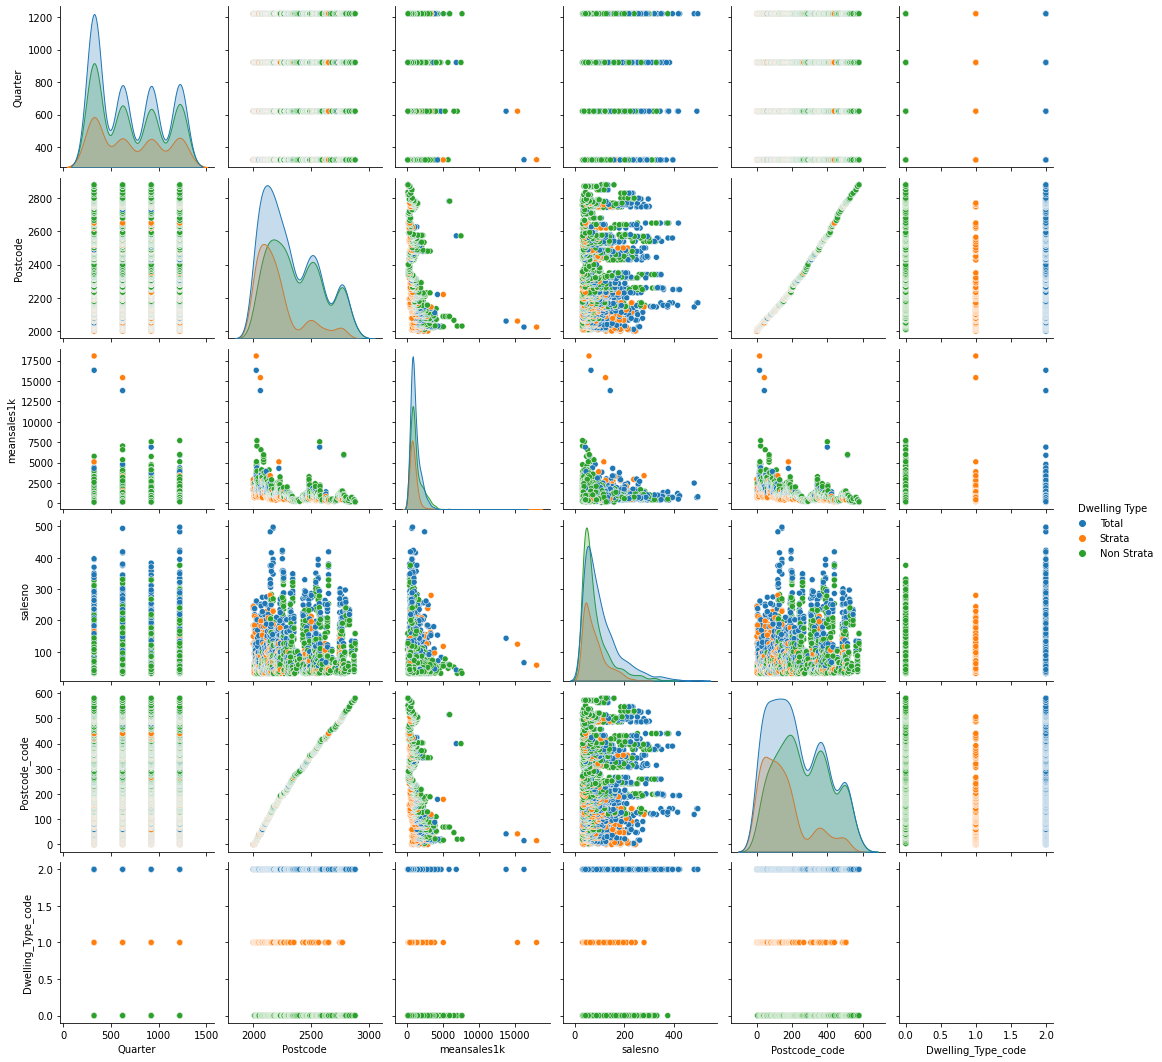

In [104]:
#Exploring relationship between variables

sns.pairplot(df, hue = 'Dwelling Type')

# Comment

Mean sales price across all mean sales price is 1.214.611 AUD.

Mean number of sales in each post code is 92 units.	

# Logistic regression

In this section, I will attempt to classify dwelling type based on data we have on Postcode, means sales price and sales number.

The models I use will be: logistic regression, KNN and Gaussian/Multinomial Naive Bayes.

In this logistic regression, because only 2 classes are allowed, I deleted all "Total" rows.

After splitting into training and test data (10% of data used for testing), I used RFE to look for the best features that can help with the model. The RFE suggests using just one feature Sales number.


In [28]:
#Simplifying the Dwelling type to be just Non strata or Strata

df_d = df[df["Dwelling Type"] != 'Total']

In [29]:
df_d.head()

,Quarter,Postcode,Dwelling Type,meansales1k,salesno,Postcode_code,Dwelling_Type_code
1,322,2000,Strata,1731,126,0.0,1.0
4,322,2007,Strata,1034,37,1.0,1.0
7,322,2008,Strata,900,35,2.0,1.0
9,322,2009,Strata,1427,49,3.0,1.0
11,322,2010,Non Strata,2254,36,4.0,0.0


In [30]:
df_d.shape

(1947, 7)

In [31]:
df_d.corr()

,Quarter,Postcode,meansales1k,salesno,Postcode_code,Dwelling_Type_code
Quarter,1.000000,-0.022639,0.060076,0.055313,-0.018409,0.019338
Postcode,-0.022639,1.000000,-0.387749,0.071795,0.968671,-0.131239
meansales1k,0.060076,-0.387749,1.000000,-0.156436,-0.408130,-0.008092
salesno,0.055313,0.071795,-0.156436,1.000000,0.161288,0.361831
Postcode_code,-0.018409,0.968671,-0.408130,0.161288,1.000000,0.105903
Dwelling_Type_code,0.019338,-0.131239,-0.008092,0.361831,0.105903,1.000000


# Comment 

This shows us that dwelling type correlates most with post code and sales number.

In [32]:
train, test = train_test_split(df_d, test_size=0.1, random_state=142)
print(train.shape)
print(test.shape)

(1752, 7)
(195, 7)


In [33]:
X = df_d[['meansales1k', 'salesno', 'Postcode_code']]
y = df_d['Dwelling_Type_code']

In [34]:
lr = LogisticRegression()

lr.fit(X,y)
rfe = RFE(lr)
rfe_model = rfe.fit(X, y)
print("No. of features: ", rfe_model.n_features_)
print("Selected features: ", rfe_model.support_)
print("Features ranking: ", rfe_model.ranking_)

No. of features:  1
Selected features:  [False  True False]
Features ranking:  [2 1 3]


# Comment

RFE shows that we should we 1 feature that is Sales number

We will try using just Sales number as input to our Logistic regression model, and then just Post code as input. And we calculate accuracy scores as below

In [35]:
Xa = train[['salesno']]
ya = train['Dwelling_Type_code']

Xat = test[['salesno']]
yat = test['Dwelling_Type_code']

lr.fit(Xa, ya)

LogisticRegression()

In [36]:
y_pred_train_a = lr.predict(Xa)
y_pred_test_a = lr.predict(Xat)

# calculating accuracy score on training set
print("Acc on training set: ", accuracy_score(ya, y_pred_train_a))

# calculating accuracy score on test set
print("Acc on test set: ", accuracy_score(yat, y_pred_test_a))

Acc on training set:  0.6529680365296804
Acc on test set:  0.6358974358974359


In [37]:
Xb = train[['Postcode_code']]
yb = train['Dwelling_Type_code']

Xbt = test[['Postcode_code']]
ybt = test['Dwelling_Type_code']

lr.fit(Xb, yb)

LogisticRegression()

In [38]:
y_pred_train_b = lr.predict(Xb)
y_pred_test_b = lr.predict(Xbt)

# calculating accuracy score on training set
print("Acc on training set: ", accuracy_score(yb, y_pred_train_b))

# calculating accuracy score on test set
print("Acc on test set: ", accuracy_score(ybt, y_pred_test_b))

Acc on training set:  0.6992009132420092
Acc on test set:  0.6871794871794872


# Comment 

Comparing the two models, it looks like Post codes help predict dwelling type slightly better than Sales number.

Picking the best results on test set, accuracy is at 68.7% for logistic regression model. 

# KNN Classification

We put all available features in the input to the mode: post code, sales number and mean sales price

- First, we try to manually change K from 1 to 41 to find the best number K and plot error level for each K number. It looks like error keeps increasing with higher K numbers.
- Secondly we use GridsearchCV to find the best K. From here we find 2 is the best K, and accuracy is higher than logistic regression at 88.9 %
- Thirdly, we want to plot the mean and standard deviation of the accuracy of the model across the K values. We see that the accuracy doesn't change much with increasing K values.

In [105]:
X_train = train[['Postcode_code', 'salesno', 'meansales1k']]
y_train = train['Dwelling_Type_code']

X_test = test[['Postcode_code', 'salesno', 'meansales1k']]
y_test = test['Dwelling_Type_code']

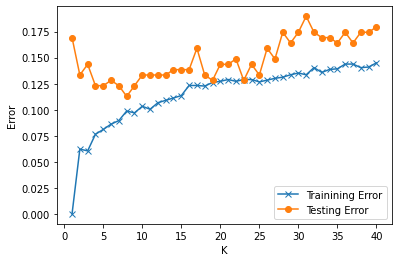

In [106]:
# Plot the accurcy trend w.r.t. K
training_error=list()
testing_error=list()

for i in range(1, 41):
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(X_train, y_train)
    training_error.append(1.0-accuracy_score(clf.predict(X_train), y_train))
    testing_error.append(1.0-accuracy_score(clf.predict(X_test), y_test))

# Plot the relationship
plt.plot(range(1, 41), training_error, marker='x', label='Trainining Error')
plt.plot(range(1, 41), testing_error, marker='o', label='Testing Error')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

In [107]:
# Define search space for parameters
parameter_grid = {'n_neighbors': range(1, 41)}

# Create the machine learning model
knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(X_train, y_train)

# Identify the best parameter(s)
print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  2
The accuracy:  0.8892857142857142


In [108]:
#Getting the mean and standard deviations of accuracy from the search process

cv_scores = clf.cv_results_['mean_test_score']
cv_scores_std = clf.cv_results_['std_test_score']

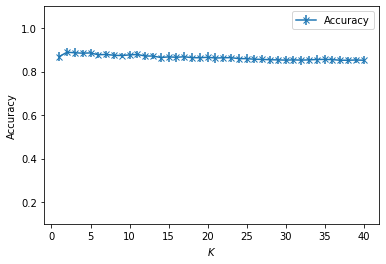

In [109]:
# Plot the relationship

k_range = range(1, 41, 1)

plt.errorbar(k_range, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.ylim([0.1, 1.1])
plt.xlabel('$K$')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Gaussian NB and Multinomial NB

Another classifer model is Naive Bayes, including Gaussian and multinomial NB. In this section we trying using these models to predict dwelling type based on the same features we used for KNN.

It can be seen the Gaussian Naive Bayes does better than Multinomial, at 71.1% accuracy versus 49.2%.

This still does not perform as well as KNN in this case.

In [110]:
# Create and training a Gaussian Naive Bayes classifier model
clf_gnn = GaussianNB()
clf_gnn.fit(X_train, y_train)

# Use the model to predict testing data
y_pred = clf_gnn.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('Testing accuracy is: %.4f\n' % accuracy)

Testing accuracy is: 0.7128



In [111]:
# Use 10-fold cross validation to show a more robust prediction accuracy
clf = GaussianNB()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
print('Gaussian Naive Bayes accuracy range: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (scores.min(), scores.max(), scores.mean(), scores.std()))

Gaussian Naive Bayes accuracy range: [0.5026, 0.8821]; mean: 0.7118; std: 0.1402



In [112]:
# Create and training a Multinomial Naive Bayes classifier model

clf_mnb = MultinomialNB()
clf_mnb.fit(X_train, y_train)

MultinomialNB()

In [113]:
# Evaluate the model
y_pred = clf_mnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy is: %.4f\n' % accuracy)

Accuracy is: 0.5487



In [114]:
# Use 10-fold cross validation to show a more robust prediction accuracy
clf = MultinomialNB()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
print('Multinomial Naive Bayes accuracy range: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (scores.min(), scores.max(), scores.mean(), scores.std()))

Multinomial Naive Bayes accuracy range: [0.3795, 0.6103]; mean: 0.4925; std: 0.0625



# Final comment

After combining data from 5 different quarters from 2021 to 2022, I cleaned and explored the sales dataset for properties in NSW. I've attempted to classify dwelling type (Strata or non-strata) based on postcode, sales number and mean sales price.

I've used logistic regression, KNN, and Naive Bayes to solve the problem and found that KNN has the highest accuracy at 88.9%.

For further exploration, I think it could be interesting to observe change of price and sales number over 1 year and fit a linear regression model on it. It could also be interesting to use K means clustering to find clusters of data that are similar, this time looking for post codes that could be similar to each other by number of sales and mean sales price.